I've been quietly obsessing over lock-in amplifiers ever since I read about them in Chapter 8 of *The Art of Electronics*. Now that I've had a few months to process the concept as a background task, I decided to whip up a Python model of a lock-in amp, just for the hell of it. 

# Background

Lock-in amplifiers are a type of lab equipment used for pulling really weak signals out of overpowering noise. Horowitz and Hill deem it "a method of considerable subtlety", which is refined way of saying "a cool trick of applied mathematics". A lock-in amplifier relies on the fact that, over a large time interval (much greater than any single period), the average DC value of any given sine wave is zero. 

<AxesSubplot:>

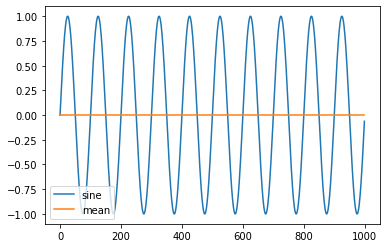

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

def sine_wave(freq, phase=0, Fs=10000):
    ph_rad = (phase/360.0)*(2.0*np.pi)
    return np.array([np.sin(((2 * np.pi * freq * a) / Fs) + ph_rad) for a in range(Fs)])

sine = sine_wave(100)
mean = np.array([np.mean(sine)] * len(sine))
df = pd.DataFrame({'sine':sine_wave(100), 
                   'mean':mean})
df[:1000].plot()

However, this ceases to be true when two sinusoids of equal frequency and phase are multiplied together. In this case, instead of averaging out to zero, the product of the two waves have a nonzero mean value.

<AxesSubplot:>

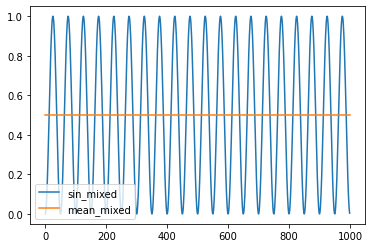

In [6]:
df['sin_mixed']  = np.multiply(df.sine, df.sine)
df['mean_mixed'] = np.mean(df.sin_mixed)
df[['sin_mixed','mean_mixed']][:1000].plot()

This DC voltage produced by the product of the two waves is *very* sensitive to changes in frequency. The plots below show that a 101Hz signal has a mean value of zero when multiplied by a 100Hz signal. 

<AxesSubplot:>

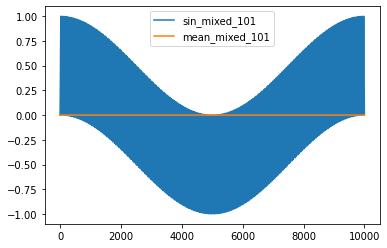

In [7]:
df['sin_mixed_101'] = np.multiply(df.sine, sine_wave(101))
df['mean_mixed_101'] = np.mean(df.sin_mixed_101)
df[['sin_mixed_101','mean_mixed_101']].plot()

This is really useful in situations where you have a signal of a known frequency. With the proper equipment, you can "lock in" to your known-frequency signal, and track changes to the amplitude and phase of that signal - *even in the presence of overwhelming noise.* 

You can show this pretty easily by just scaling down one of the waves in our prior example, and burying it in noise. (This signal is about 20dB below the noise floor in this case.)

<AxesSubplot:>

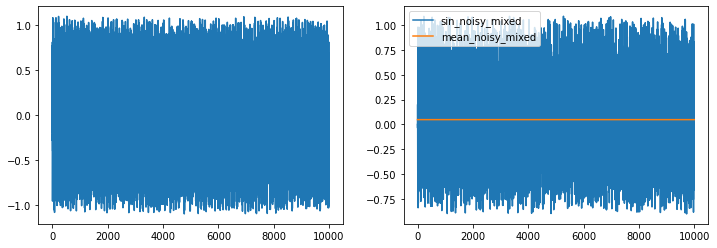

In [8]:
noise_fl         = np.array([(2 * np.random.random() - 1) for a in range(10000)])
df['sine_noisy'] = np.add(noise_fl, 0.1*df['sine'])

df['sin_noisy_mixed']  = np.multiply(df.sine_noisy, df.sine)
df['mean_noisy_mixed'] = df['sin_noisy_mixed'].mean()

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)

df['sine_noisy'].plot(ax=axes[0])
df[['sin_noisy_mixed', 'mean_noisy_mixed']].plot(ax=axes[1])

It doesn't look like much at the prior altitude, but it's definitely the signal we're looking for. That's because the lock-in output scales with the amplitude of both the input signal and the reference waveform:

$$U_{out}=\frac{1}{2}V_{sig}V_{ref}cos(\theta)$$

As a result, the lock-in amp has a small (but meaningful) amplitude:

<AxesSubplot:>

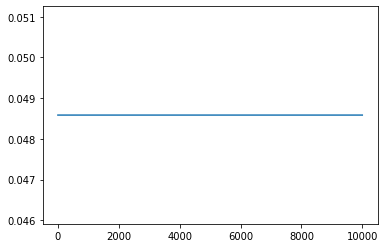

In [9]:
df['mean_noisy_mixed'].plot()

Great! We can pull really weak signals out of seemingly endless noise. So, why haven't we used this technology to revolutionize all communications with infite signal-to-noise ratio? 

Like all real systems, there's a tradeoff, and for a lock-in amplifier, that tradeoff is *time*. Lock-in amps rely on a persistent periodic signal - without one, there isn't anything to lock on to! That's the catch of multiplying two signals of identical frequencies together: it takes time for that DC offset component to form. 

A second tradeoff of the averaging method becomes obvious when you consider how to implement the averaging in a practical manner. Since we're talking about this in the context of electronics: one of the simplest ways to average, electronically, is to just filter by frequency, and it doesn't get much simpler than a single pole lowpass filter for a nice gentle average. The result looks pretty good when applied to the product of two sine waves:

<AxesSubplot:>

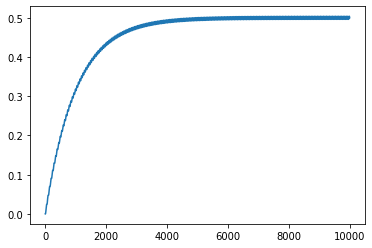

In [10]:
def lowpass(x, alpha=0.001):
    data = [x[0]]
    for a in x[1:]:
        data.append(data[-1] + (alpha*(a-data[-1])))
    return np.array(data)

df['sin_mixed_lp'] = lowpass(df.sin_mixed)
df['sin_mixed_lp'].plot()

...but it starts to break down when you filter the noisy signals, which can contain large fluctuations that aren't necessarily real:

<AxesSubplot:>

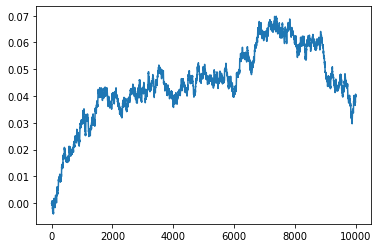

In [11]:
df['sin_noisy_mixed_lp'] = lowpass(df.sin_noisy_mixed)
df['sin_noisy_mixed_lp'].plot()

We can clean get rid of some of that statistical noise junk by rerunning the filter, of course, but that takes time, and also robs the lock-in of a bit of responsiveness. 

<AxesSubplot:>

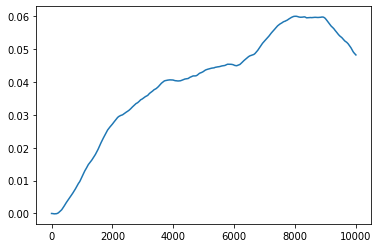

In [12]:
df['sin_noisy_mixed_lp2'] = lowpass(df.sin_noisy_mixed_lp)
df['sin_noisy_mixed_lp2'].plot()

On top of all this, lock-in amps are highly sensitive to phase differences between reference and signal tones. Take a look at the plots below, where our noisy signal is mixed with waves 45 and 90 degrees offset from it.

<AxesSubplot:>

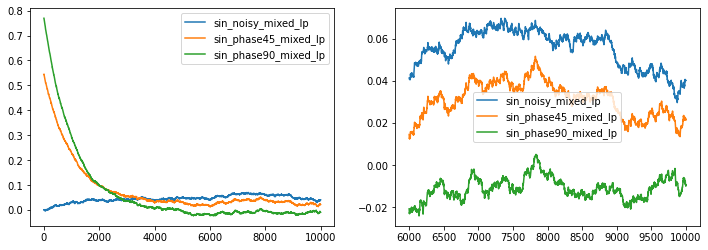

In [13]:
df['sin_phase45_mixed']  = np.multiply(df.sine_noisy, sine_wave(100, phase=45))
df['sin_phase90_mixed']  = np.multiply(df.sine_noisy, sine_wave(100, phase=90))
df['sin_phase45_mixed_lp'] = lowpass(df['sin_phase45_mixed'])
df['sin_phase90_mixed_lp']   = lowpass(df['sin_phase90_mixed'])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)

df[['sin_noisy_mixed_lp','sin_phase45_mixed_lp','sin_phase90_mixed_lp']].plot(ax=axes[0])
df[['sin_noisy_mixed_lp','sin_phase45_mixed_lp','sin_phase90_mixed_lp']][6000:].plot(ax=axes[1])

These plots illustrate that there's a component of phase sensitivity. As the phase of signal moves farther and farther out of phase with the reference, the lock-in output starts to trend downwards, closer to zero. You can see, too, why lock-ins require time to settle out to a final value - the left plot shows how signals that are greatly out of phase with one another can produce an initial signal value where none should exist! The right plot, however, shows how the filtered, 90-degree offset signal (green trace) declines over time to the correct average value of approximately zero. 

# Quadrature Output

Like all lab equipment, lock-in amplifiers were originally analog devices. Analog lock-ins required a bit of tedious work to get optimum performance from amplifier - typically adjusting the phase of the reference so as to be in-phase with the target signal. This could prove time consuming given the time delay required for the output to stabilize! However, advances in digital technology have since yielded some nice improvements for lock-in amplifiers: 

* digitally generated, near-perfect reference signals,
* simultaneous sine and cosine mixing,
* DSP based output filter - easily and accurately change filter order and corner!

This easy access to both sine-mixed and cosine-mixed signals allow us to plot the output of a digital lock-in amplifier as a quadrature modulated signal, which shows changes in both the magnitude and phase of the lock-in vector:

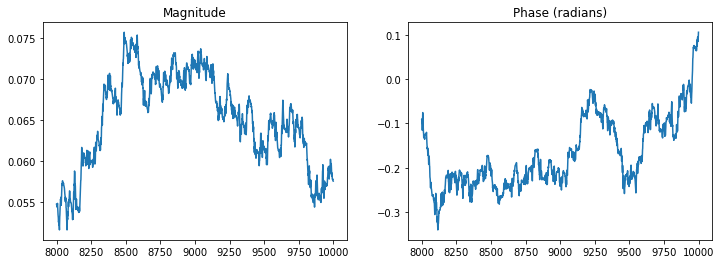

In [258]:
def cosine_wave(freq, phase=0, Fs=10000):
    ph_rad = (phase/360.0)*(2.0*np.pi)
    return np.array([np.cos(((2 * np.pi * freq * a) / Fs) + ph_rad) for a in range(Fs)])

df['cos_noisy_mixed']    = np.multiply(df.sine_noisy, cosine_wave(100))
df['cos_noisy_mixed_lp'] = lowpass(df['cos_noisy_mixed'])

df['noisy_quad_mag'] = np.sqrt(np.add(np.square(df['cos_noisy_mixed_lp']),
                       np.square(df['sin_noisy_mixed_lp'])))
df['noisy_quad_pha'] = np.arctan2(df['cos_noisy_mixed_lp'], df['sin_noisy_mixed_lp'])

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12,4)
axes[0].set_title('Magnitude')
axes[1].set_title('Phase (radians)')
df['noisy_quad_mag'][8000:].plot(ax=axes[0])
df['noisy_quad_pha'][8000:].plot(ax=axes[1])

# Bonus Material

If you've got a copy of *The Art of Electronics, 3rd Edition* handy, you can read Horowitz and Hill's description of lock-in amplifiers in section 8.14.1. *AoE*'s description focuses more heavily on analog lock-in techniques, and touches a bit on the phase detectors, which form the circuit basis for analog lock-in amplifiers. It starts on page 575. 

Zurich Instruments, a prominent vendor of lock-in amplifiers, has [a great overview of the state of the art on their website](https://www.zhinst.com/applications/principles-of-lock-in-detection). They also have some great, mathematically formal descriptions of what's happening in the time and frequency domains during the process of lock-in amplification. (With nice pretty pictures, too!) 

Also - this is my first time writing a blog post as a Jupyter notebook. If you want to pull down a copy to tool around with, grab it [here](/assets/)!